In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.datasets import load_breast_cancer
from lightgbm.sklearn import LGBMClassifier
from bonsai.base.c45tree import C45Tree
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Any

In [26]:
from numba import njit, prange, jit
@njit(fastmath=True)
def gini_impurity(X: np.ndarray):
    result = 0
    classes = np.unique(X[:, -1])
    for c in classes:
        result += ((X[:, -1]==c).sum()/X.shape[0])**2
    return 1 - result

@njit(fastmath=True)
def gini_index(Xs: List[np.ndarray]):
#     total_size = np.sum(np.array([X.shape[0] for X in Xs]))
    total_size = 0
    for X in Xs:
        total_size += X.shape[0]
    if total_size == 0:
        return 1
    result = 0
    for X in Xs:
        result += X.shape[0]/total_size * gini_impurity(X)
    return result
#     return np.sum([X.shape[0]/total_size * gini_impurity(X) for X in Xs])

In [27]:
@njit
def split_data(X: np.ndarray, feature_index: int, split_value: float):
    is_na = np.isnan(X[:, feature_index])
    left = X[(X[:, feature_index] < split_value) | is_na]
    right = X[(X[:, feature_index] >= split_value) | is_na]
    return left, right

In [28]:
@njit
def generate_split_points(X: np.ndarray, feature_index: int):
    splits = np.sort(X[:, feature_index])
    return set(splits[~np.isnan(splits)])

In [160]:
from dataclasses import dataclass
from numba.experimental import jitclass
from typing import Union
from numba import int32, float32, deferred_type

@dataclass
class Leaf:
    value: int
    n_samples: int

# leaf_spec = [
#     ('value', int32), 
#     ('n_samples', int32)
# ]

# @jitclass(leaf_spec)
# class Leaf:
#     def __init__(self, value, n_samples):
#         self.value = value
#         self.n_samples = n_samples


@dataclass
class Tree:
    left: Union['Tree', Leaf]
    right: Union['Tree', Leaf]
    split_feature: int
    split_value: float
    n_samples: int

# leaf_type = deferred_type()
# leaf_type.define(Leaf.class_type.instance_type)

# tree_spec = [
#     ('left', leaf_type), 
#     ('right', leaf_type), 
#     ('split_feature', int32), 
#     ('split_value', float32), 
#     ('n_samples', int32)
# ]

# @jitclass(tree_spec)
# class Tree:
#     def __init__(self, left, right, split_feature, split_value, n_samples):
#         self.left = left
#         self.right = right
#         self.split_feature = split_feature
#         self.split_value = split_value
#         self.n_samples = n_samples

In [161]:
@njit(fastmath=True)
def get_split(X: np.ndarray):
    best_gini, best_feature, best_split, best_groups = np.inf, None, None, None
    for feature_index in range(X.shape[1]-1):
        for split_value in generate_split_points(X, feature_index):
            groups = split_data(X, feature_index, split_value)
            gini = gini_index(groups)
            if gini < best_gini:
                best_gini = gini
                best_feature = feature_index
                best_split = split_value
                best_groups = groups
    current_gini = gini_impurity(X)
    if current_gini < best_gini:
        return 0, 0, 0, (None, None)
    return best_feature, best_split, best_gini, best_groups

In [162]:
# @njit
# def most_frequent(a: np.ndarray):
#     values, counts = np.unique(a, return_counts=True)
#     ind = np.argmax(counts)
#     return values[ind]

@njit
def most_frequent(x):
    return np.argmax(np.bincount(x.astype(np.int32)))

In [163]:
@jit
def test(X, last_gini, t):
    if np.sum(X) < 10:
        return (last_gini, 3, 3)
    else:
        return t

In [164]:
test.signatures

[]

In [165]:
# @jit()
def decision_tree(X: np.ndarray, last_gini=None):
    best_feature, best_split, best_gini, (left, right) = get_split(X)
    if left is None or last_gini == best_gini:
        return Leaf(most_frequent(X[:, -1]), X.shape[0])
    
    if len(np.unique(left[:, -1])) == 1:
        left_tree = Leaf(most_frequent(left[:, -1]), left.shape[0])
    elif len(np.unique(left[:, -1])) == 0:
        left_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
        left_tree = decision_tree(left, last_gini=best_gini)
    
    if len(np.unique(right[:, -1])) == 1:
        right_tree = Leaf(most_frequent(right[:, -1]), right.shape[0])
    elif len(np.unique(right[:, -1])) == 0:
        right_tree = Leaf(most_frequent(X[:, -1]), 1)
    else:
        right_tree = decision_tree(right, last_gini=best_gini)
    
    return Tree(left_tree, right_tree, best_feature, best_split, X.shape[0])

In [166]:
# @jit
# def decision_tree(X: np.ndarray, last_gini=None):
#     best_feature, best_split, best_gini, (left, right) = get_split(X)
#     if left is None or last_gini == best_gini:
#         return (most_frequent(X[:, -1]), X.shape[0])
    
#     if len(np.unique(left[:, -1])) == 1:
#         left_tree = (most_frequent(left[:, -1]), left.shape[0])
#     elif len(np.unique(left[:, -1])) == 0:
#         left_tree = (most_frequent(X[:, -1]), 1)
#     else:
#         left_tree = decision_tree(left, last_gini=best_gini)
    
#     if len(np.unique(right[:, -1])) == 1:
#         right_tree = (most_frequent(right[:, -1]), right.shape[0])
#     elif len(np.unique(right[:, -1])) == 0:
#         right_tree = (most_frequent(X[:, -1]), 1)
#     else:
#         right_tree = decision_tree(right, last_gini=best_gini)
    
#     return Tree(None, , left_tree, right_tree, best_feature, best_split)

In [167]:
def predict(tree: Union[Tree, Leaf], sample: np.ndarray):
    if isinstance(tree, Leaf):
        return tree.value
    
    if sample[tree.split_feature] < tree.split_value:
        return predict(tree.left, sample)
    elif np.isnan(sample[tree.split_feature]):
        total_samples = tree.left.n_samples + tree.right.n_samples
        return (predict(tree.left, sample)*tree.left.n_samples + predict(tree.right, sample)*tree.right.n_samples)/total_samples
    
    return predict(tree.right, sample)

In [168]:
class DecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=0):
        pass
    
    def fit(self, data, labels):
        self.tree = decision_tree(np.concatenate([data, labels[:, None]], axis=1))
    
    def predict(self, data):
        return np.array([np.round(predict(self.tree, data[i, :])) for i in range(data.shape[0])])

In [169]:
from scipy.stats import mode
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=10):
        self.n_trees = n_trees
        
    def _boostrap_data(self, data):
        return data[np.random.choice(data.shape[0], size=data.shape[0]), :]
    
    def fit(self, data, labels):
        self.trees = [decision_tree(self._boostrap_data(np.concatenate([data, labels[:, None]], axis=1))) 
                      for i in range(self.n_trees)]
        
    def _predict_single(self, row):
        return mode([np.round(predict(t, row)) for t in self.trees]).mode
    
    def predict(self, data):
        return np.array([self._predict_single(data[i, :]) for i in range(data.shape[0])])

In [170]:
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train[y_train == 1, 4] = np.nan
X_test[y_test == 0, 4] = np.nan

In [173]:
dt = DecisionTree()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.9035087719298246

In [24]:
np.isfortran(X_train)

False

In [178]:
rf = RandomForest(n_trees=1000)
rf.fit(X_train, y_train)

In [179]:
rf.score(X_test, y_test)

0.9385964912280702

In [174]:
from sklearn.metrics import accuracy_score
from bonsai.base.regtree import RegTree
from bonsai.ensemble.randomforests import RandomForests
from bonsai.ensemble.paloboost import PaloBoost
c45 = PaloBoost()
c45.fit(X_train.astype(np.int64), y_train.astype(np.int64))
# c45.score(X_test, y_test)
accuracy_score(y_train, np.round(c45.predict(X_train))), accuracy_score(y_test, np.round(c45.predict(X_test)))

(0.9692307692307692, 0.8947368421052632)

In [180]:
from sklearn.metrics import accuracy_score
from bonsai.base.regtree import RegTree
from bonsai.ensemble.randomforests import RandomForests
from bonsai.ensemble.paloforest import PaloForest
c45 = PaloForest(n_paloboost=100)
c45.fit(X_train.astype(np.int64), y_train.astype(np.int64))
# c45.score(X_test, y_test)
accuracy_score(y_train, np.round(c45.predict(X_train))), accuracy_score(y_test, np.round(c45.predict(X_test)))

(0.9714285714285714, 0.9035087719298246)

In [19]:
lgbm = LGBMClassifier(n_jobs=-1)
lgbm.fit(X_train, y_train)
lgbm.score(X_test, y_test)

0.0

In [182]:
def impute_data(X, y, negative_pattern, positive_pattern):
    for i in range(X.shape[1]):
        if np.random.rand() < negative_pattern[i]:
            X[y == 0, i] = np.nan
        
        if np.random.rand() < positive_pattern[i]:
            X[y == 1, i] = np.nan

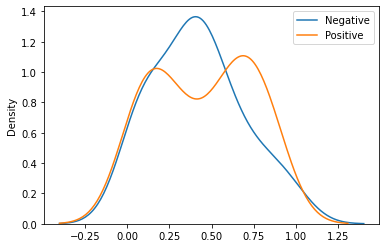

In [183]:
neg_pattern = np.random.rand(X.shape[1])
pos_pattern = np.random.rand(X.shape[1])
sns.kdeplot(neg_pattern, label='Negative')
sns.kdeplot(pos_pattern, label='Positive')
plt.legend()

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
impute_data(X_train, y_train, neg_pattern, pos_pattern)
impute_data(X_test, y_test, pos_pattern, neg_pattern)

In [99]:
dt = DecisionTree()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.9473684210526315

In [100]:
lgbm = LGBMClassifier(n_jobs=-1)
lgbm.fit(X_train, y_train)
lgbm.score(X_test, y_test)

0.32456140350877194

In [139]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
mlp = make_pipeline(
    SimpleImputer(), 
    MLPClassifier(hidden_layer_sizes=(5, ))
)
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.956140350877193

In [278]:
import pandas as pd
from tqdm import tqdm
def compare_models(models, n_trials):
    results = []
    for i in tqdm(range(n_trials)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        neg_pattern = np.random.rand(X.shape[1])
        pos_pattern = np.random.rand(X.shape[1])
        impute_data(X_train, y_train, neg_pattern, pos_pattern)
        impute_data(X_test, y_test, pos_pattern, neg_pattern)
        train_nans = np.isnan(X_train).sum(axis=0)/X_train.shape[0]
        test_nans = np.isnan(X_test).sum(axis=0)/X_test.shape[0]
#         dist = np.linalg.norm(train_nans-test_nans)
        diff = np.abs(train_nans-test_nans)
        dist = np.mean(diff)#/train_nans.mean()
    
#         X_c, y_c = X.copy(), y.copy()
#         impute_data(X_c, y_c, neg_pattern, pos_pattern)
#         X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.5, shuffle=True)
#         train_nans = np.isnan(X_train_c).sum(axis=0)/X_train_c.shape[0]
#         test_nans = np.isnan(X_test_c).sum(axis=0)/X_test_c.shape[0]
#         dist = np.abs(dist - np.mean(np.abs(train_nans-test_nans)))
        
        for name, model in models:
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            
            for f, d in enumerate(diff):
                results.append({'model': name, 'trial': i, 'dist': dist, 'feature': f, 'diff': d, 'score': score})
    
    return pd.DataFrame(results)

In [306]:
from sklearn.preprocessing import StandardScaler
results = compare_models([
#     ('rf', RandomForest(n_trees=40)), 
    ('dt', DecisionTree()), 
    ('lgbm', LGBMClassifier(n_jobs=-1)), 
#     ('mlp', make_pipeline(
#         SimpleImputer(), 
#         StandardScaler(), 
#         MLPClassifier(hidden_layer_sizes=(5, ), max_iter=1400)
#     ))
], n_trials=500)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:58<00:00,  2.80it/s]


<AxesSubplot:xlabel='model', ylabel='score'>

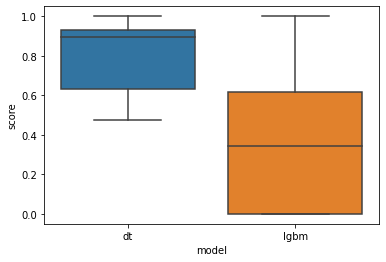

In [307]:
sns.boxplot(data=results, x='model', y='score')

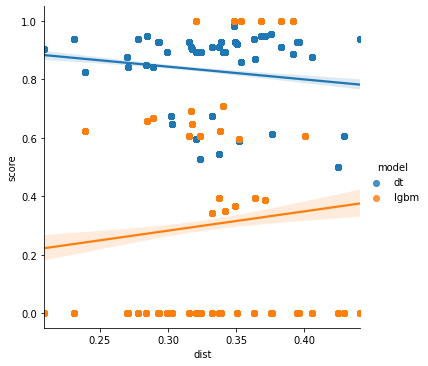

In [281]:
sns.lmplot(data=results, x='dist', y='score', hue='model')

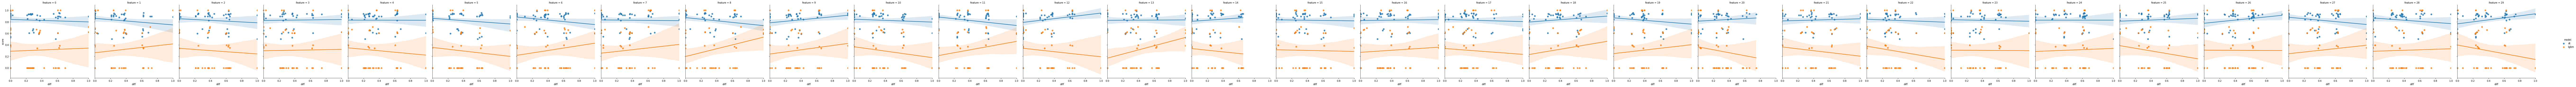

In [283]:
sns.lmplot(data=results, col='feature', x='diff', y='score', hue='model')

In [302]:
import shap
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
neg_pattern = np.random.rand(X.shape[1])
pos_pattern = np.random.rand(X.shape[1])
impute_data(X_train, y_train, neg_pattern, pos_pattern)
impute_data(X_test, y_test, pos_pattern, neg_pattern)
top_feat = np.argsort(np.abs(shap.TreeExplainer(LGBMClassifier(n_jobs=-1).fit(X_train, y_train))(X_test)[:, :, 1].values).mean(axis=0))[-20:]

In [303]:
top_feat.sort()

<AxesSubplot:>

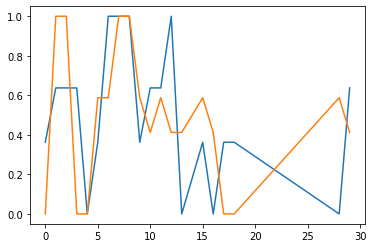

In [304]:
(pd.DataFrame(X_train).iloc[:, top_feat].isna().sum()/X_train.shape[0]).plot()
(pd.DataFrame(X_test).iloc[:, top_feat].isna().sum()/X_test.shape[0]).plot()

<AxesSubplot:>

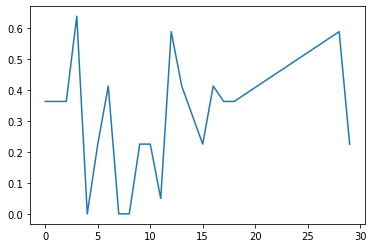

In [305]:
((pd.DataFrame(X_train).iloc[:, top_feat].isna().sum()/X_train.shape[0]) -
       pd.DataFrame(X_test).iloc[:, top_feat].isna().sum()/X_test.shape[0]).abs().plot()

In [252]:
X_c, y_c = X.copy(), y.copy()
neg_pattern = np.random.rand(X.shape[1])
    pos_pattern = np.random.rand(X.shape[1])
impute_data(X_c, y_c, neg_pattern, pos_pattern)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.5, shuffle=True)
train_nans = np.isnan(X_train).sum(axis=0)/X_train.shape[0]
test_nans = np.isnan(X_test).sum(axis=0)/X_test.shape[0]
#         dist = np.linalg.norm(train_nans-test_nans)
np.mean(np.abs(train_nans-test_nans))

0.005950086483815172

<AxesSubplot:xlabel='trial', ylabel='score'>

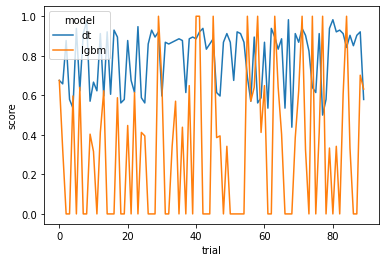

In [215]:
sns.lineplot(data=results[results.trial < 90], x='trial', y='score', hue='model')

<AxesSubplot:xlabel='dist', ylabel='score'>

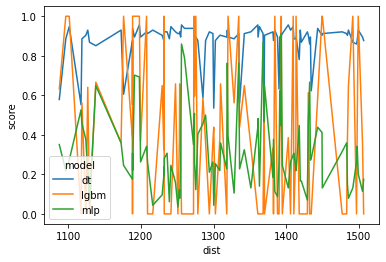

In [159]:
sns.lineplot(data=results,resultsdist', y='score', hue='model')

In [161]:
results['is_upper'] = results.dist > results.dist.median()

In [166]:
X_train[np.random.choice(X_train.shape[0], size=X_train.shape[0]), :].shape

(455, 30)

In [167]:
X_train.shape

(455, 30)

In [2]:
from bonsai.base.c45tree import C45Tree

In [214]:
print(bonsai.__file__.replace('\\', '/'))

c:/users/roel/.virtualenvs/diagcovid-ckc2berq/lib/site-packages/bonsai/__init__.py


In [3]:
t = C45Tree()